In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0, '../scripts')

import stft_zoom, display
from util import fft_frequencies
import mappings
import pickle
import PIL
import IPython.display
import detect_musical_regions

/Library/Python/3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/Library/Python/3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


### Part 1: How to extract feature from spectrogram using "mappings" script

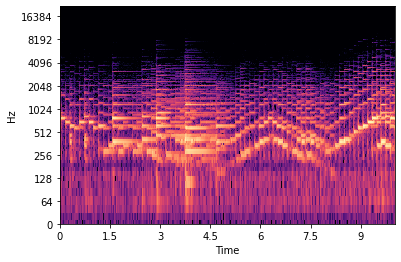

In [2]:
# Plot spectrogram from example sound file

y, sr = librosa.load('../data/example.wav', sr=44100)
n_fft = 2048
hop_size = 512
spec = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_size))
spec_db = librosa.amplitude_to_db(spec, ref=np.max)

plt.figure()
librosa.display.specshow(spec_db, sr=44100,  hop_length=512, y_axis='log', x_axis='time')

In [3]:
# Extract some features from dB spectrogram, using a 500 ms x 500 cents kernel...

kernel = [500, 500]
shannon_db = mappings.calc_map_aug2(spec_db, kernel, type='shannon', n_fft=n_fft, hop_size=hop_size)
avg_db = shannon_db = mappings.calc_map_aug2(spec_db, kernel, type='avg', n_fft=n_fft, hop_size=hop_size)
std_dev = shannon_db = mappings.calc_map_aug2(spec_db, kernel, type='std dev', n_fft=n_fft, hop_size=hop_size)

Text(0.5, 1.0, 'Standard deviation of energy in dB')

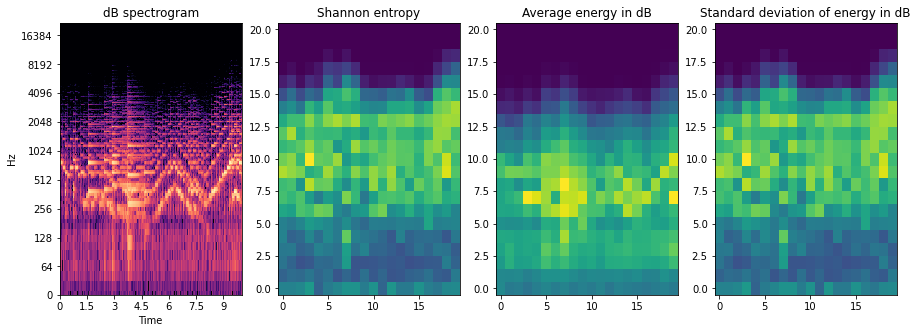

In [4]:
# ... and plot them

plt.figure(figsize=[15,5])

plt.subplot(1,4,1)
librosa.display.specshow(spec_db, sr=44100,  hop_length=512, y_axis='log', x_axis='time')
plt.title('dB spectrogram')

plt.subplot(1,4,2)
plt.imshow(shannon_db, origin='lower', aspect='auto')
plt.title('Shannon entropy')

plt.subplot(1,4,3)
plt.imshow(avg_db, origin='lower', aspect='auto')
plt.title('Average energy in dB')

plt.subplot(1,4,4)
plt.imshow(std_dev, origin='lower', aspect='auto')
plt.title('Standard deviation of energy in dB')

### Part 2: Using "stft_zoom" script to compute low cost representations of subregions of a time-frequency representation

In [5]:
# Zoom in on 5-6.5 seconds x 150-500 Hz region...

freq_range = [150,500]
time_range = [5, 6.5]

# k determines the new freq. resolution (new_resolution = k * old_resolution)
spec_zoom, x_axis, y_axis, new_sr, new_window_size, new_hop_size = stft_zoom.stft_zoom(y, freq_range, time_range, k=5)

In [6]:
print('Window size:',new_window_size)
print('Hop size:',new_hop_size)
print('Subsampling frequency:', new_sr)
print('Frequency resolution of zoomed-in region:', new_sr/ new_window_size, 'Hz')

Window size: 276
Hop size: 69
Subsampling frequency: 1191.8918918918919
Frequency resolution of zoomed-in region: 4.318448883666275 Hz


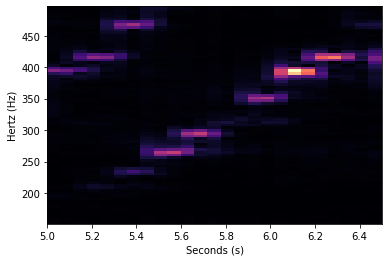

In [7]:
# Display it using "display" script (an adaptation of librosa.display)

display.specshow(spec_zoom, x_axis, y_axis)

### Part 3: How to build multi-resolution spectrogram with automatic detection of interesting subregions 

#### Part 3.1 Initialize data structures

In [8]:
from classes import SingleResSpectrogram, MultiResSpectrogram

In [9]:
y, sr = librosa.load('../data/example.wav', sr=44100)
n_fft = 2048
hop_size = 512
spec = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_size))

# Every SingleResSpectrogram has a spectrogram matrix and two arrays: x_axis and y_axis
x_axis, y_axis = stft_zoom.get_axes_values(sr, 0, [0,len(y)/sr], spec.shape)
base_spec = SingleResSpectrogram(spec, x_axis, y_axis)

In [10]:
# Every MultiResSpectrogram starts with a base single resolution spectrogram
multires_spec = MultiResSpectrogram(base_spec)

#### Part 3.2 Detecting interesting subregions with the "detect_musical_regions" script

In [11]:
# First, load Naive-Bayes model trained using 800x800 kernel and piano roll + harmonics reference value
model = pickle.load(open('renyi_shannon_prollharm_model.sav', 'rb'))

# Detect musical subregions using 800x800 kernel and a probability threshold of 80%

kernel = [800,800]
threshold = 0.8
indices, shape_feature_map = detect_musical_regions.detect_musical_regions(model, spec, mode='threshold', pct_or_threshold=threshold)

/Library/Python/3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianNB from version 0.19.0 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [12]:
# Convert detected indices to freq. ranges and time ranges
interesting_regions = detect_musical_regions.musical_regions_to_ranges(indices, shape_feature_map, x_axis, y_axis, kernel)

In [13]:
# Detected regions are given by [freq_range, time_range] 
interesting_regions[:5]

[([258.3984375, 430.6640625], [3.205574912891986, 4.006968641114983]),
 ([258.3984375, 430.6640625], [1.602787456445993, 2.4041811846689893]),
 ([689.0625, 1098.193359375], [8.815331010452962, 9.616724738675957]),
 ([430.6640625, 689.0625], [8.815331010452962, 9.616724738675957]),
 ([430.6640625, 689.0625], [2.4041811846689893, 3.205574912891986])]

#### Part 3.2: Refining detected regions using "stft_zoom"

In [14]:
for subregion in interesting_regions:
    freq_range = subregion[0]
    time_range = subregion[1]
    
    # Zoom in using "stft_zoom" (it prints out what subband processing method was applied)
    spec_zoom, x_axis, y_axis, new_sr, window_size, hop_size = stft_zoom.stft_zoom(y, freq_range, time_range, sr=sr, original_window_size=n_fft, k=3)
    
    # Each refined subregion is a SingleResSpectrogram of its own...
    refined_subspec = SingleResSpectrogram(spec_zoom, x_axis, y_axis)
    # ...that is inserted into a MultiResSpectrogram
    multires_spec.insert_zoom(multires_spec.base_spec, refined_subspec, zoom_level=1)

ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
undersampling
[1644.18945312 2977.78320312]
(3150, 0) [172.216796875, 1505.810546875]
ring mod + lpf
ring mod + lpf
undersampling
[1644.18945312 2977.78320312]
(3150, 0) [172.216796875, 1505.810546875]
ring mod + lpf
ring mod + lpf
ring mod + lpf
undersampling
[1644.18945312 2977.78320312]
(3150, 0) [172.216796875, 1505.810546875]
ring mod + lpf
undersampling
[1644.18945312 2977.78320312]
(3150, 0) [172.216796875, 1505.810546875]
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + 

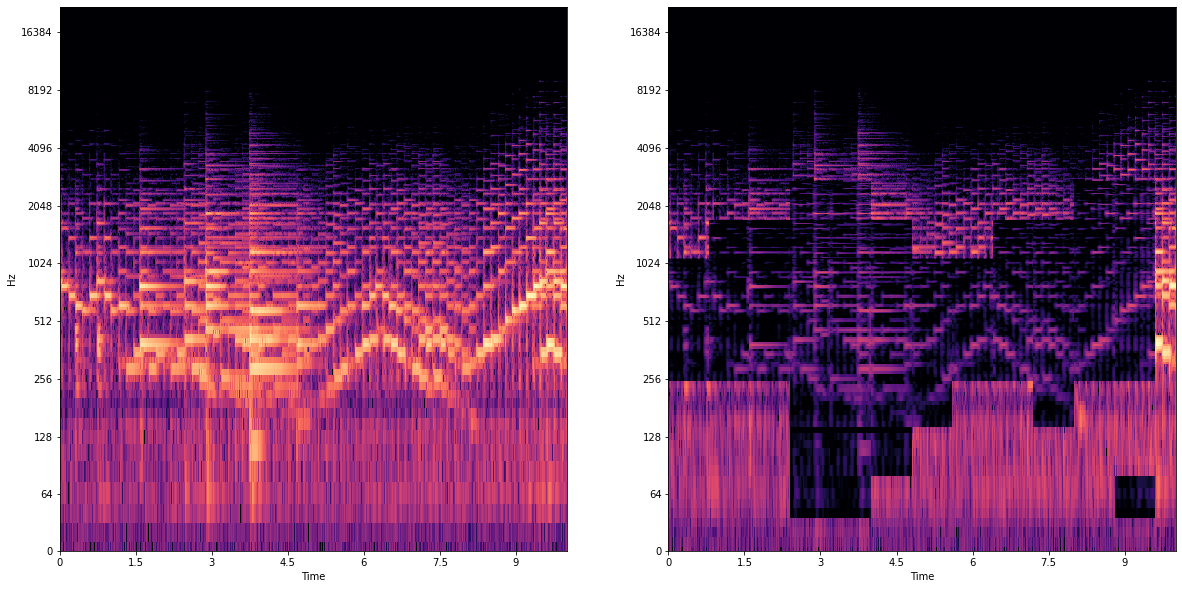

In [15]:
# Then, we can generate a visualization
vis = multires_spec.generate_visualization()

# ...and compare it to the original single resolution spectrogram
plt.figure(figsize=[20,10])

plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), y_axis='log', x_axis='time', sr=sr)

plt.subplot(1,2,2)
librosa.display.specshow(librosa.amplitude_to_db(vis, ref=np.max), y_axis='log', x_axis='time', sr=sr)